# Wrangle & Analyze WeRateDogs Data

<hr>

#### Table of Contents:
* [Project Description](#Project-Description)  
* [Notebook Setup](#Notebook-Setup)  
<br/> 
* [Gathering Data](#Gathering-Data)
    * [Enhanced Twitter Archive](#Gether:-Enhanced-Twitter-Archive)  
    * [Image Predictions File](#Gether:-Image-Predictions-File)  
    * [Twitter API File](#Gether:-Twitter-API-File)  
<br/> 
* [Assessing Data](#Assessing-Data)
    * [Twitter Archive Data](#Assess:-Twitter-Archive-Data)  
    * [Image Predictions](#Assess:-Image-Predictions)  
    * [Twitter API Data](#Assess:-Twitter-API-Data)  
<br/> 
* [Cleaning Data](#Cleaning-Data)
    * [Twitter Archive Data](#Clean:-Twitter-Archive-Data)  
    * [Image Predictions](#Clean:-Image-Predictions)  
    * [Twitter API Data](#Clean:-Twitter-API-Data)  
    * [Merge Datasets](#Clean:-Merge-Datasets)  
<br/> 
* [Analyzing Data](#Analyzing-Data)
    * [Tweets over time](#Tweets-over-time)
    * [Tweets by source](#Tweets-by-Source)
    * [Dog names](#Dog-names)
    * [Dog types](#Dog-types)
    * [Dog breeds](#Dog-Breeds)
    * [Rating](#Rating)
    * [Favorites and Retweets](#Favorites-and-Retweets)  
<br/> 
* [Conclusions](#Conclusions)
<hr>

## Project Description

Real-world data rarely comes clean. Using Python and its libraries, I will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. I will document my wrangling efforts in a Jupyter Notebook, plus showcase them through analyses and visualizations using Python.

The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

<p align="center">
  <img src="img/dog-rates-social.jpg" width="600">
</p>

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).

<p align="center">
  <img src="img/data.png" width="1300">
</p>

Retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered from Twitter's API, which I will do.

## Notebook Setup

Load libraries and set pandas display options.

<hr>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import requests
import json
from datetime import datetime
import re
from stop_words import get_stop_words
from functools import reduce

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# pandas settings
pd.set_option('display.max_colwidth', -1)

# matplotlib magic
%matplotlib inline

## Gathering Data

Gather data from various sources and a variety of file formats.

<hr>

* [Enhanced Twitter Archive](#Gether:-Enhanced-Twitter-Archive)  
* [Image Predictions File](#Gether:-Image-Predictions-File)  
* [Twitter API File](#Gether:-Twitter-API-File)


### Gather: Enhanced Twitter Archive

This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.

In [2]:
# load twitter archive
twitter_arch = pd.read_csv("data/twitter-archive-enhanced.csv")
# use tweet id column as index
twitter_arch.set_index("tweet_id", inplace = True)
# display few lines
twitter_arch.head(3)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


### Gether: Image Predictions File

This file contains top three predictions of dog breed for each dog image from the WeRateDogs archive. Table contains the top three predictions, tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

In [3]:
# get file with the image predictions
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
with open('data/image-predictions.tsv' , 'wb') as file:
    predictions = requests.get(url)
    file.write(predictions.content)

# load image predictions
image_pred = pd.read_csv('data/image-predictions.tsv', sep = '\t')
# use tweet id column as index
image_pred.set_index("tweet_id", inplace = True)
# display few lines
image_pred.head(3)

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### Gether: Twitter API File

Retweet count and favorite count are two of the notable column omissions of Twitter data archive. Fortunately, this additional data can be gathered from Twitter's API. Twitter API file contains tweet id, favorite count and retweet count. 

In [4]:
# load twitter API data
with open('data/tweet-json.txt') as f:
    twitter_api = pd.DataFrame((json.loads(line) for line in f), columns = ['id', 'favorite_count', 'retweet_count'])

# change column names
twitter_api.columns = ['tweet_id', 'favorites', 'retweets']
# use tweet id column as index
twitter_api.set_index('tweet_id', inplace = True)
# display few lines
twitter_api.head(3)

,favorites,retweets
tweet_id,,
892420643555336193,39467,8853
892177421306343426,33819,6514
891815181378084864,25461,4328



## Assessing Data

Assess data visually and programmatically for quality and tidiness issues using pandas.

<hr>

* [Twitter Archive Data](#Assess:-Twitter-Archive-Data)  
* [Image Predictions](#Assess:-Image-Predictions)  
* [Twitter API Data](#Assess:-Twitter-API-Data)

### Assess: Twitter Archive Data

In [5]:
# display sample of data
twitter_arch.sample(3)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
738537504001953792,NaN,NaN,2016-06-03 01:07:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bayley. She fell asleep trying to escape her evil fence enclosure. 11/10 night night puppo https://t.co/AxSiqAKEKu,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/738537504001953792/photo/1,https://twitter.com/dog_rates/status/738537504001953792/photo/1",11,10,Bayley,None,None,None,puppo
769695466921623552,NaN,NaN,2016-08-28 00:37:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Titan. He's trying to make friends. Offering up his favorite stick. 13/10 philanthropic af https://t.co/vhrkz0dK4v,NaN,NaN,NaN,https://twitter.com/dog_rates/status/769695466921623552/photo/1,13,10,Titan,None,None,None,None
801285448605831168,NaN,NaN,2016-11-23 04:45:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",oh h*ck 10/10 https://t.co/bC69RrW559,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801285448605831168/photo/1,10,10,None,None,None,None,None


In [6]:
# print a summary of a DataFrame
twitter_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), object(10)
memory usa

In [7]:
# check if ids are unique
twitter_arch.index.is_unique

True

In [8]:
# check number of replies
np.isfinite(twitter_arch.in_reply_to_status_id).sum()

78

In [9]:
# check values in sources
twitter_arch.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [10]:
# check quality of text
twitter_arch.text.sample(3)

tweet_id
683098815881154561    aahhhhkslaldhwnxmzbbs 12/10 for being da smooshiest https://t.co/UOPdXmUz4H                                                  
774757898236878852    This is Finley. She's a Beneboop Cumbersplash. 12/10 I'd do unspeakable things for Finley https://t.co/dS8SCbNF9P            
757400162377592832    She walks herself up and down the train to be petted by all the passengers. 13/10 I can't handle this https://t.co/gwKCspY8N2
Name: text, dtype: object

In [11]:
# check number of retweets
np.isfinite(twitter_arch.retweeted_status_id).sum()

181

In [12]:
# check expanded urls
twitter_arch[~twitter_arch.expanded_urls.str.startswith(('https://twitter.com','http://twitter.com', 'https://vine.co'), na=False)].sample(3)[['text','expanded_urls']]

,text,expanded_urls
tweet_id,,
819952236453363712,This is Oliver. He has dreams of being a service puppo so he can help his owner. 13/10 selfless af\n\nmake it happen:\nhttps://t.co/f5WMsx0a9K https://t.co/6lJz0DKZIb,"https://www.gofundme.com/servicedogoliver,https://twitter.com/dog_rates/status/819952236453363712/photo/1"
860981674716409858,"RT @dog_rates: Meet Lorenzo. He's an avid nifty hat wearer and absolute 13/10, but he needs your help to beat cancer. Link below\n\nhttps://t…","https://www.gofundme.com/help-lorenzo-beat-cancer,https://twitter.com/dog_rates/status/860563773140209665/photo/1,https://twitter.com/dog_rates/status/860563773140209665/photo/1"
668967877119254528,12/10 good shit Bubka\n@wane15,NaN


In [13]:
# check for two or more urls in the expanded urls
twitter_arch[twitter_arch.expanded_urls.str.contains(',', na = False)].expanded_urls.count()

639

In [14]:
# check rating denominator
twitter_arch.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [15]:
# check ratings with denominator greather than 10
twitter_arch[twitter_arch.rating_denominator > 10][['text', 'rating_denominator']]

,text,rating_denominator
tweet_id,,
832088576586297345,@docmisterio account started on 11/15/15,15
820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11
758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50
713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90


In [16]:
# check rating numerator
twitter_arch.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [17]:
# check for any float ratings in the text column
twitter_arch[twitter_arch.text.str.contains(r'\d+\.\d+\/\d+')][['text','rating_denominator', 'rating_numerator']]

,text,rating_denominator,rating_numerator
tweet_id,,,
883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",10,5
832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",10,75
786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",10,75
778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,10,27
681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,10,5
680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,10,26


In [18]:
# check name of dog
twitter_arch.name.value_counts()

None          745
a             55 
Charlie       12 
Cooper        11 
Lucy          11 
Oliver        11 
Penny         10 
Tucker        10 
Lola          10 
Bo            9  
Winston       9  
the           8  
Sadie         8  
Buddy         7  
Toby          7  
an            7  
Bailey        7  
Daisy         7  
Koda          6  
Bella         6  
Jack          6  
Leo           6  
Jax           6  
Rusty         6  
Milo          6  
Dave          6  
Oscar         6  
Scout         6  
Stanley       6  
Sammy         5  
             ..  
Pawnd         1  
Bilbo         1  
Furzey        1  
Fillup        1  
Tyrus         1  
Autumn        1  
Marvin        1  
Bert          1  
Sparky        1  
Ruffles       1  
Mitch         1  
Tedrick       1  
Bronte        1  
Theo          1  
Striker       1  
Maks          1  
Howie         1  
Devón         1  
Kaia          1  
Ronduh        1  
Bluebert      1  
officially    1  
Hamrick       1  
Vinscent      1  
Adele     

In [19]:
# check for stop words in dog name
# https://stackoverflow.com/a/5486535/7382214
stop_words = set(get_stop_words('en'))

count = 0
for word in twitter_arch.name:
    if word.lower() in stop_words:
        count += 1
print('Rows with stop words:', count)

Rows with stop words: 83


In [20]:
# check if dogs have more than one category assigned
categories = ['doggo', 'floofer', 'pupper', 'puppo']

for category in categories:
    twitter_arch[category] = twitter_arch[category].apply(lambda x: 0 if x == 'None' else 1)

twitter_arch['number_categories'] = twitter_arch.loc[:,categories].sum(axis = 1)

In [21]:
# dogs categories
twitter_arch['number_categories'].value_counts()

0    1976
1    366 
2    14  
Name: number_categories, dtype: int64

#### Quality & Tidiness Issues

- some of the gathered tweets are replies and should be removed;
- the timestamp has an incorrect datatype - is an object, should be DateTime;
- source is an HTML element - its text should be extracted;
- some rows in the text column begin from 'RT @dog_rates:';
- some rows in the text column have leading and/or trailing whitespace;
- some of the gathered tweets are retweets;
- we have 59 missing expanded urls;
- we have 639 expanded urls which contain more than one url address;
- denominator of some ratings is not 10;
- numerator of some ratings is greater than 10 (does not need to be cleaned);
- float ratings have been incorrectly read from the text of tweet;
- 'None' in the name should be convert to NaN;
- we have stop words in the name column;
- dog 'stage' classification (doggo, floofer, pupper or puppo) should be one column;
- some dogs have more than one category assigned;

### Assess: Image Predictions

In [22]:
# display sample of data
image_pred.sample(3)

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
842535590457499648,https://pbs.twimg.com/media/C7FJpgVW4AIDzi6.jpg,1,Pembroke,0.685084,True,Cardigan,0.314608,True,basenji,0.000160,True
887705289381826560,https://pbs.twimg.com/media/DFHDQBbXgAEqY7t.jpg,1,basset,0.821664,True,redbone,0.087582,True,Weimaraner,0.026236,True
666835007768551424,https://pbs.twimg.com/media/CUES51dXIAEahyG.jpg,1,Airedale,0.448459,True,toy_poodle,0.124030,True,teddy,0.110183,False


In [23]:
# print a summary of a DataFrame
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 11 columns):
jpg_url    2075 non-null object
img_num    2075 non-null int64
p1         2075 non-null object
p1_conf    2075 non-null float64
p1_dog     2075 non-null bool
p2         2075 non-null object
p2_conf    2075 non-null float64
p2_dog     2075 non-null bool
p3         2075 non-null object
p3_conf    2075 non-null float64
p3_dog     2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 152.0+ KB


In [24]:
# check if ids are unique
image_pred.index.is_unique

True

In [25]:
# check jpg_url
image_pred[~image_pred.jpg_url.str.endswith(('.jpg', '.png'), na = False)].jpg_url.count()

0

In [26]:
# check image number
image_pred.img_num.value_counts()

1    1780
2    198 
3    66  
4    31  
Name: img_num, dtype: int64

In [27]:
# check 1st prediction
image_pred.p1.sample(3)

tweet_id
879008229531029506    vizsla
883360690899218434    chow  
819006400881917954    prison
Name: p1, dtype: object

In [28]:
# check dog predictions
image_pred.p1_dog.count()

2075

#### Quality & Tidiness Issues

- the dataset has 2075 entries, while twitter archive dataset has 2356 entries;
- column names are confusing and do not give much information about the content;
- dog breeds contain underscores, and have different case formatting;
- only 2075 images have been classified as dog images for top prediction;
- dataset should be merged with the twitter archive dataset;

### Assess: Twitter API Data

In [29]:
# display sample of data
twitter_api.sample(3)

,favorites,retweets
tweet_id,,
825120256414846976,0,1483
765222098633691136,12902,3914
675109292475830276,3006,1259


In [30]:
# print a summary of a DataFrame
twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 892420643555336193 to 666020888022790149
Data columns (total 2 columns):
favorites    2354 non-null int64
retweets     2354 non-null int64
dtypes: int64(2)
memory usage: 55.2 KB


In [31]:
# check if ids are unique
twitter_arch.index.is_unique

True

#### Quality & Tidiness Issues

- twitter archive dataset has 2356 entries, while twitter API data has 2354;
- dataset should be merged with the twitter archive dataset;

## Cleaning Data

Using pandas, clean the quality and tidiness issues identified in the [Assessing Data](#Assessing-Data) section.

<hr>

* [Twitter Archive Data](#Clean:-Twitter-Archive-Data)  
* [Image Predictions](#Clean:-Image-Predictions)  
* [Twitter API Data](#Clean:-Twitter-API-Data)
* [Merge Datasets](#Merge-Datasets)

### Clean: Twitter Archive Data

In [32]:
# create a copy of dataset
twitter_arch_clean = twitter_arch.copy()

In [33]:
# display sample of data
twitter_arch_clean.sample(3)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,number_categories
tweet_id,,,,,,,,,,,,,,,,,
667502640335572993,NaN,NaN,2015-11-20 00:40:05 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Say hello to Hall and Oates. Oates is winking and Hall is contemplating the artistic entropy of the universe. 11/10s https://t.co/n5Wtb5Hvsl,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667502640335572993/photo/1,11,10,Hall,0,0,0,0,0
865359393868664832,NaN,NaN,2017-05-19 00:12:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sammy. Her tongue ejects without warning sometimes. It's a serious condition. Needs a hefty dose from a BlepiPen. 13/10 https://t.co/g20EmqK7vc,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/865359393868664832/photo/1,https://twitter.com/dog_rates/status/865359393868664832/photo/1",13,10,Sammy,0,0,0,0,0
770069151037685760,NaN,NaN,2016-08-29 01:22:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Carbon. This is his first time swimming. He's having a h*ckin blast. 10/10 we should all be this happy https://t.co/mADHGenzFS,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770069151037685760/photo/1,10,10,Carbon,0,0,0,0,0


#### Define

Some of the gathered tweets are replies and retweets
- remove retweets data from the dataset
- remove columns with retweet and replies information

#### Code

In [34]:
# display shape of dataframe
twitter_arch_clean.shape

(2356, 17)

In [35]:
# drop retweets                                                 
twitter_arch_clean = twitter_arch_clean[twitter_arch_clean['retweeted_status_id'].isnull()]

In [36]:
# display all columns
twitter_arch_clean.columns

Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'number_categories'],
      dtype='object')

In [37]:
# drop unnecessary columns
twitter_arch_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id','retweeted_status_timestamp'], axis = 1, inplace = True)

In [38]:
# display shape of dataframe
twitter_arch_clean.shape

(2175, 12)

In [39]:
# display cleaned dataset
twitter_arch_clean.sample(3)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,number_categories
tweet_id,,,,,,,,,,,,
672068090318987265,2015-12-02 15:01:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Gizmo. He's upset because he's not sure if he's really big or the shopping cart is really small. 7/10 https://t.co/XkMtCGhr4a,https://twitter.com/dog_rates/status/672068090318987265/photo/1,7,10,Gizmo,0,0,0,0,0
672614745925664768,2015-12-04 03:13:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Norman. Doesn't bark much. Very docile pup. Up to date on current events. Overall nifty pupper. 6/10 https://t.co/ntxsR98f3U,https://twitter.com/dog_rates/status/672614745925664768/photo/1,6,10,Norman,0,0,1,0,1
683449695444799489,2016-01-03 00:47:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I just want to be friends with this dog. Appears to be into the sports. A true brobean. 10/10 would introduce to mom https://t.co/1Z7Q6svWpe,https://twitter.com/dog_rates/status/683449695444799489/photo/1,10,10,None,0,0,0,0,0


#### Define

The timestamp has an incorrect datatype - is an object, should be DateTime
* convert to datetime

#### Code

In [40]:
# convert to datetime
twitter_arch_clean.timestamp = pd.to_datetime(twitter_arch_clean.timestamp)

In [41]:
# display dataset types
twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 892420643555336193 to 666020888022790149
Data columns (total 12 columns):
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null int64
floofer               2175 non-null int64
pupper                2175 non-null int64
puppo                 2175 non-null int64
number_categories     2175 non-null int64
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 220.9+ KB


#### Define

Source is an HTML element - its text should be extracted
* extract inner text of the HTML elements

#### Code

In [42]:
# extract inner text from HTML
twitter_arch_clean.source = twitter_arch_clean.source.apply(lambda x: re.findall(r'>(.*)<', x)[0])

In [43]:
# display new source
twitter_arch_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene    91  
Twitter Web Client     31  
TweetDeck              11  
Name: source, dtype: int64

#### Define

Some rows have leading and/or trailing whitespace:
- strip whitespace

#### Code

In [44]:
# strip leading and trailing space
twitter_arch_clean.text = twitter_arch_clean.text.str.strip()

#### Define

We have 639 expanded urls which contain more than one url address and 59 missing expanded urls
- build correct links by using tweet id

#### Code

In [45]:
# fix expanded urls
for index, column in twitter_arch_clean.iterrows():
    twitter_arch_clean.loc[index, 'expanded_urls'] = 'https://twitter.com/dog_rates/status/' + str(index)

twitter_arch_clean.sample(3)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,number_categories
tweet_id,,,,,,,,,,,,
861005113778896900,2017-05-06 23:49:50,Twitter for iPhone,This is Burt. He thinks your thesis statement is comically underdeveloped. 12/10 intellectual af https://t.co/jH6EN9cEn6,https://twitter.com/dog_rates/status/861005113778896900,12,10,Burt,0,0,0,0,0
692530551048294401,2016-01-28 02:12:04,Twitter for iPhone,Say hello to Cody. He's been to like 80 countries and is way more cultured than you. He wanted me to say that. 10/10 https://t.co/Iv3flDTpXu,https://twitter.com/dog_rates/status/692530551048294401,10,10,Cody,0,0,0,0,0
878281511006478336,2017-06-23 16:00:04,Twitter for iPhone,"Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY https://t.co/lUiQH219v6",https://twitter.com/dog_rates/status/878281511006478336,13,10,Shadow,0,0,0,0,0


#### Define

Float ratings have been incorrectly read from the text of tweet

- gather correct rating when rating is a fraction

#### Code

In [46]:
# example of tweet with incorrect rating
twitter_arch_clean[twitter_arch_clean.text.str.contains(r'\d+\.\d+\/\d+')][['text','rating_denominator', 'rating_numerator']].sample(1)

,text,rating_denominator,rating_numerator
tweet_id,,,
786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",10,75


In [47]:
# convert both columns to floats
twitter_arch_clean['rating_numerator'] = twitter_arch_clean['rating_numerator'].astype(float)
twitter_arch_clean['rating_denominator'] = twitter_arch_clean['rating_denominator'].astype(float)

# find columns with fractions
fraction_ratings = twitter_arch_clean[twitter_arch_clean.text.str.contains(r'\d+\.\d+\/\d+', na = False)].index

# extract correct rating and replace incorrect one
for index in fraction_ratings:
    rating = re.search('\d+\.\d+\/\d+', twitter_arch_clean.loc[index,:].text).group(0)
    twitter_arch_clean.at[index,'rating_numerator'], twitter_arch_clean.at[index,'rating_denominator'] = rating.split('/')

In [48]:
# display sample of fixed data
twitter_arch_clean.loc[fraction_ratings,:][['text','rating_denominator', 'rating_numerator']].sample(1)

,text,rating_denominator,rating_numerator
tweet_id,,,
786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",10.0,9.75


#### Define

Denominator of some ratings is not 10. Numerator of some ratings is greater than 10. The fact that the rating numerators are greater than the denominators does not need to be cleaned, however I will introduce a normalized rating which will be easier to plot.

- fix incorrectly read ratings
- add normalized rating

#### Code

In [49]:
# save index of tweets with denominator greater than 10
high_denominator = twitter_arch[twitter_arch.rating_denominator > 10].index

# display sample of data with denominator greater than 10
twitter_arch_clean.loc[high_denominator,:][['text','rating_denominator', 'rating_numerator']].sample(1)

C:\Users\StempBar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,text,rating_denominator,rating_numerator
tweet_id,,,
775096608509886464,NaN,NaN,NaN


In [50]:
# fix rating manually for tweets for which rating was read incorrectly
twitter_arch_clean.loc[832088576586297345, 'rating_denominator'] = 0
twitter_arch_clean.loc[832088576586297345, 'rating_numerator'] = 0

twitter_arch_clean.loc[775096608509886464, 'rating_denominator'] = 10
twitter_arch_clean.loc[775096608509886464, 'rating_numerator'] = 14

twitter_arch_clean.loc[740373189193256964, 'rating_denominator'] = 10
twitter_arch_clean.loc[740373189193256964, 'rating_numerator'] = 14

twitter_arch_clean.loc[722974582966214656, 'rating_denominator'] = 10
twitter_arch_clean.loc[722974582966214656, 'rating_numerator'] = 13

twitter_arch_clean.loc[716439118184652801, 'rating_denominator'] = 10
twitter_arch_clean.loc[716439118184652801, 'rating_numerator'] = 11

twitter_arch_clean.loc[682962037429899265, 'rating_denominator'] = 10
twitter_arch_clean.loc[682962037429899265, 'rating_numerator'] = 10

In [51]:
# display sample of fixed rating
twitter_arch_clean.loc[high_denominator,:][['text','rating_denominator', 'rating_numerator']].sample(1)

,text,rating_denominator,rating_numerator
tweet_id,,,
686035780142297088,"Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating",20.0,4.0


In [52]:
# add normalized rating
twitter_arch_clean['rating'] = twitter_arch_clean['rating_numerator'] / twitter_arch_clean['rating_denominator']

In [53]:
# display sample of data with the new column
twitter_arch_clean[['text','rating_denominator', 'rating_numerator', 'rating']].sample(1)

,text,rating_denominator,rating_numerator,rating
tweet_id,,,,
667070482143944705,After much debate this dog is being upgraded to 10/10. I repeat 10/10,10.0,10.0,1.0


#### Define

We have stop words in the name column and 'None' values
- replace stop words with the correct name
- replace None with Nan

#### Code

In [54]:
# adapted from https://stackoverflow.com/a/35976915/7382214

# keywords after which a dog name appears in the sentence
keywords = ('named', 'This is', 'Say hello to', 'Meet', 'Here we have', 'name is', 'name to')
# build regex pattern to find names
regex = r"\b(?:{})\b (\w+)".format("|".join(keywords))

# loop over the rows, and find dog names
for index, column in twitter_arch_clean.iterrows():
    split_list = re.split(regex, str(twitter_arch_clean.loc[index, 'text']), flags = re.IGNORECASE)
    if len(split_list) > 1 and split_list[1] not in stop_words:
        twitter_arch_clean.loc[index, 'name'] = split_list[1].title()
    else:
        twitter_arch_clean.loc[index, 'name'] = np.nan

#### Define

Dog 'stage' classification (doggo, floofer, pupper or puppo) should be one column. Some dogs have more than one category assigned

#### Code

In [55]:
# display sample of dataframe
twitter_arch_clean.head(2)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,number_categories,rating
tweet_id,,,,,,,,,,,,,
892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193,13.0,10.0,Phineas,0.0,0.0,0.0,0.0,0.0,1.3
892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426,13.0,10.0,Tilly,0.0,0.0,0.0,0.0,0.0,1.3


In [56]:
# read dog types from text column
for index, column in twitter_arch_clean.iterrows():
    for word in ['puppo', 'pupper', 'doggo', 'floofer']:
        if word.lower() in str(twitter_arch_clean.loc[index, 'text']).lower():
            twitter_arch_clean.loc[index, 'dog_type'] = word.title()
            
# drop old columns
twitter_arch_clean.drop(['puppo',
                       'pupper',
                       'doggo',
                       'floofer'],
                      axis=1, inplace=True)

In [57]:
# display sample of fixed data
twitter_arch_clean.sample(3)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,number_categories,rating,dog_type
tweet_id,,,,,,,,,,
689275259254616065,2016-01-19 02:36:42,Twitter for iPhone,Meet Lucky. He was showing his friends an extreme pogo stick trick when he completely lost control. 10/10 still rad https://t.co/K55XrIoePl,https://twitter.com/dog_rates/status/689275259254616065,10.0,10.0,Lucky,0.0,1.0,NaN
668988183816871936,2015-11-24 03:03:06,Twitter for iPhone,Honor to rate this dog. Lots of fur on him. Two massive tumors on back. Should get checked out. Very neat tho. 7/10 https://t.co/bMhs18elNF,https://twitter.com/dog_rates/status/668988183816871936,7.0,10.0,NaN,0.0,0.7,NaN
773308824254029826,2016-09-06 23:56:05,Twitter for iPhone,This is Bungalo. She uses that face to get what she wants. It works unbelievably well. 12/10 would never say no to https://t.co/0Fcft7jl4N,https://twitter.com/dog_rates/status/773308824254029826,12.0,10.0,Bungalo,0.0,1.2,NaN


### Clean: Image Predictions

In [58]:
# create a copy of dataset
image_pred_clean = image_pred.copy()

In [59]:
# display sample of data
image_pred_clean.sample(3)

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
686050296934563840,https://pbs.twimg.com/media/CYVXBb9WsAAwL3p.jpg,1,Pomeranian,0.985789,True,keeshond,0.004083,True,Pekinese,0.003334,True
739544079319588864,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
849776966551130114,https://pbs.twimg.com/media/C8sDpDWWsAE5P08.jpg,2,Chihuahua,0.292092,True,toy_terrier,0.136852,True,bonnet,0.103111,False


#### Define

Column names are confusing and do not give much information about the content.  
- Change column names to more descriptive ones.

#### Code

In [60]:
# display current labels
image_pred_clean.columns

Index(['jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [61]:
# change labels
image_pred_clean.columns = ['image_url', 
                            'img_number', 
                            '1st_prediction',
                            '1st_prediction_confidence',
                            '1st_prediction_isdog',
                            '2nd_prediction',
                            '2nd_prediction_confidence',
                            '2nd_prediction_isdog',
                            '3rd_prediction',
                            '3rd_prediction_confidence',
                            '3rd_prediction_isdog']

In [62]:
# display new labels
image_pred_clean.columns

Index(['image_url', 'img_number', '1st_prediction',
       '1st_prediction_confidence', '1st_prediction_isdog', '2nd_prediction',
       '2nd_prediction_confidence', '2nd_prediction_isdog', '3rd_prediction',
       '3rd_prediction_confidence', '3rd_prediction_isdog'],
      dtype='object')

#### Define

Dog breeds contain underscores, and have different case formatting
- Replace underscores with whitespace
- Capitalize the first letter of each word

#### Code

In [63]:
# columns with dog breed
dog_breed_cols = ['1st_prediction', '2nd_prediction', '3rd_prediction']

# remove underscore and capitalize the first letter of each word 
for column in dog_breed_cols:
    image_pred_clean[column] = image_pred_clean[column].str.replace('_', ' ').str.title()

In [64]:
# display sample of changes
image_pred_clean[dog_breed_cols].sample(3)

,1st_prediction,2nd_prediction,3rd_prediction
tweet_id,,,
768970937022709760,Pomeranian,Golden Retriever,Mousetrap
765669560888528897,Beagle,Walker Hound,Basset
887517139158093824,Limousine,Tow Truck,Shopping Cart


#### Define

Only 2075 images have been classified as dog images for top prediction
- If 1st predictions is not a dog breed, then use dog breed predicted in the 2nd or 3rd predicion

#### Code

In [65]:
# adapted from https://stackoverflow.com/a/26887820/7382214
# build function to determine dog breed
# if no breed detected, set value to NaN

def get_breed(row):
    if row['1st_prediction_isdog'] == True:
        return row['1st_prediction'], row['1st_prediction_confidence']
    if row['2nd_prediction_isdog'] == True:
        return row['2nd_prediction'], row['2nd_prediction_confidence']
    if row['3rd_prediction_isdog'] == True:
        return row['3rd_prediction'], row['3rd_prediction_confidence']
    return np.nan, np.nan

# apply function to dataset
# create new columns with data
image_pred_clean[['breed_predicted', 'prediction_confidence']] = pd.DataFrame(image_pred_clean.apply(lambda row: get_breed(row), axis = 1).tolist(), index = image_pred_clean.index) 

# drop old columns
image_pred_clean.drop(['1st_prediction',
                       '1st_prediction_confidence',
                       '1st_prediction_isdog',
                       '2nd_prediction',
                       '2nd_prediction_confidence',
                       '2nd_prediction_isdog',
                       '3rd_prediction',
                       '3rd_prediction_confidence',
                       '3rd_prediction_isdog'],
                      axis=1, inplace=True)

# drop rows without dog breed prediction
image_pred_clean.dropna(subset = ['breed_predicted', 'prediction_confidence'], inplace = True)

In [66]:
# display sample of cleaned dataset
image_pred_clean.sample(3)

,image_url,img_number,breed_predicted,prediction_confidence
tweet_id,,,,
821522889702862852,https://pbs.twimg.com/media/C2aitIUXAAAG-Wi.jpg,1,Doberman,0.763539
676575501977128964,https://pbs.twimg.com/media/CWOt07EUsAAnOYW.jpg,1,Yorkshire Terrier,0.073144
667793409583771648,https://pbs.twimg.com/media/CUR6jqVWsAEgGot.jpg,1,Dalmatian,0.535073


This concludes cleaning activities for the Image Predictions dataset. The remaining task is to merge it with the Twitter archive data, which is covered in the [Clean: Merge Datasets](#Clean:-Merge-Datasets) section.

### Clean: Twitter API Data

In [67]:
# display sample of data
twitter_api.sample(3)

,favorites,retweets
tweet_id,,
782969140009107456,26949,8521
831670449226514432,11469,2059
671533943490011136,1092,631


There is no need to perform cleaning tasks in this data set, except for merging it with the Twitter archive data, which is covered in the next section.

### Clean: Merge Datasets

In [68]:
# join datasets
df = reduce(lambda left, right: pd.merge(left, right, on='tweet_id'), [twitter_arch_clean, image_pred_clean, twitter_api])

In [69]:
# display new dataset
df.sample(3)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,number_categories,rating,dog_type,image_url,img_number,breed_predicted,prediction_confidence,favorites,retweets
tweet_id,,,,,,,,,,,,,,,,
744234799360020481,2016-06-18 18:26:18,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481,13.0,10.0,NaN,1.0,1.3,Doggo,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,Labrador Retriever,0.825333,131075,79515
676936541936185344,2015-12-16 01:27:03,Twitter for iPhone,Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.co/mqvaxleHRz,https://twitter.com/dog_rates/status/676936541936185344,8.0,10.0,NaN,1.0,0.8,Pupper,https://pbs.twimg.com/media/CWT2MUgWIAECWig.jpg,1,Chesapeake Bay Retriever,0.545286,13809,5515
816816676327063552,2017-01-05 01:20:46,Twitter for iPhone,This is Timber. He misses Christmas. Specifically the presents part. 12/10 cheer pup Timber https://t.co/dVVavqpeF9,https://twitter.com/dog_rates/status/816816676327063552,12.0,10.0,Timber,0.0,1.2,NaN,https://pbs.twimg.com/media/C1XqbhXXUAElpfI.jpg,1,Malamute,0.668164,11071,2361


In [70]:
# save new dataset to csv
df.to_csv('twitter_archive_master.csv')

## Analyzing Data

Analyze and visualize data using matplotlib.

* [Tweets over time](#Tweets-over-time)
* [Tweets by source](#Tweets-by-Source)
* [Dog names](#Dog-names)
* [Dog types](#Dog-types)
* [Dog breeds](#Dog-Breeds)
* [Rating](#Rating)
* [Favorites and Retweets](#Favorites-and-Retweets)

<hr>

In [71]:
# scatter plot function
def plot_scatter(x, y, title="", xlabel="", ylabel="", xscale="linear", yscale="linear", color="#3F5D7D", xticks=None, yticks=None):
    
    plt.figure(figsize=(10,7))   

    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.grid(which='major', axis='both', linestyle='--', alpha=0.5, color="#3F5D7D")

    if xticks is None:
        plt.xticks(fontsize=14)
    else:
        plt.xticks(xticks)

    if yticks is None:
        plt.yticks(fontsize=14) 
    else:
        plt.yticks(yticks)
        
    plt.scatter(x, 
                y,
                color=color)

    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

    plt.title(title,
              fontsize=18,
              ha="center",
              pad=24)

    plt.xlabel(xlabel,
               fontsize=14,
               labelpad=20)

    plt.ylabel(ylabel, 
               fontsize=14,
               labelpad=20)

    return plt.show()

# hist plot function
def plot_hist(data, bins='auto', title="", xlabel="", ylabel="", rwidth=1, xlim=None, ylim=None):
    
    plt.figure(figsize=(10,7)) 

    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)    
    ax.grid(which='major', axis='y', linestyle='--', alpha=0.5, color="#3F5D7D")
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 

    if xlim is None:
        plt.xlim()
    else:
        plt.xlim(xlim)

    if ylim is None:
        plt.ylim()
    else:
        plt.ylim(ylim)
        
    plt.tick_params(axis="both", which="both", bottom=True, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True) 
    
    plt.hist(data, color="#3F5D7D", edgecolor="k", bins=bins, rwidth=rwidth)
    
    plt.title(title,
              fontsize=18)
    
    plt.xlabel(xlabel,
               fontsize=14)
    
    plt.ylabel(ylabel,
               fontsize=14)
    
    return plt.show()

# bar plot function
def plot_bar(x, y, title="", xlabel="", ylabel="", rotation=0, width=0.8):
    
    plt.figure(figsize=(10,7)) 

    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)    
    ax.grid(which='major', axis='y', linestyle='--', alpha=0.5, color="#3F5D7D")

    plt.xticks(fontsize=14, rotation=rotation)
    plt.yticks(fontsize=14) 

    plt.tick_params(axis="both", which="both", bottom=False, top=False,
                    labelbottom=True, left=False, right=False, labelleft=True) 

    bar_list = plt.bar(x, y, color="#3F5D7D", edgecolor="k", width=width)

    for a,b in zip(x, y):
        plt.text(a, b, str(round(b,2)), ha='center', va='bottom', fontsize=12)

    plt.title(title,
              fontsize=18)
    
    plt.xlabel(xlabel,
               fontsize=14)
    
    plt.ylabel(ylabel,
               fontsize=14)

    return plt.show()

# horizontal bar plot function
def plot_barh(x, y, title="", xlabel="", ylabel="", rotation=0):
    
    plt.figure(figsize=(10,7)) 

    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)    
    ax.grid(which='major', axis='x', linestyle='--', alpha=0.5, color="#3F5D7D")

    plt.xticks(fontsize=14, rotation=rotation)
    plt.yticks(fontsize=14) 

    plt.tick_params(axis="both", which="both", bottom=False, top=False,
                    labelbottom=True, left=False, right=False, labelleft=True) 

    bar_list = plt.barh(x,y, color="#3F5D7D", edgecolor="k")

    for a, b in zip(x, y):
        plt.text(b, a, str(round(b,2)), ha='right', va='center', fontsize=10, color="#ffffff")

    plt.title(title,
              fontsize=18)
    
    plt.xlabel(xlabel,
               fontsize=14)
    
    plt.ylabel(ylabel,
               fontsize=14)

    return plt.show()

# line plot function
def plot_line(x, y, title="", xlabel="", ylabel="", marker=None, linestyle="-", xlim=None, ylim=None, xrotation=0):
    
    plt.figure(figsize=(10, 7))   

    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.grid(which='major', axis='both', linestyle='--', alpha=0.5, color="#3F5D7D")

    plt.yticks(fontsize=14)    
    plt.xticks(fontsize=14, rotation=xrotation)   

    if xlim is None:
        plt.xlim()
    else:
        plt.xlim(xlim)

    if ylim is None:
        plt.ylim()
    else:
        plt.ylim(ylim)
    
    plt.plot(x, y, marker=marker, linestyle=linestyle, color="#3F5D7D")

    plt.title(title,
              fontsize=18)
    
    plt.xlabel(xlabel,
               fontsize=14)
    
    plt.ylabel(ylabel,
               fontsize=14)

    return plt.show()

In [72]:
# display sample of data
df.sample(3)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,number_categories,rating,dog_type,image_url,img_number,breed_predicted,prediction_confidence,favorites,retweets
tweet_id,,,,,,,,,,,,,,,,
802952499103731712,2016-11-27 19:09:28,Twitter for iPhone,This is Marley. She's having a ruff day. Pretty pupset. 12/10 would assist https://t.co/yLm7hQ6UXh,https://twitter.com/dog_rates/status/802952499103731712,12.0,10.0,Marley,0.0,1.2,NaN,https://pbs.twimg.com/media/CySpCSHXcAAN-qC.jpg,1,Chow,0.944032,10085,2336
667119796878725120,2015-11-18 23:18:48,Twitter for iPhone,This is Gabe. He is a southern Baklava. Gabe has always wanted to fit in with the other bananas. 10/10 fabulous https://t.co/3LZrJzg3BJ,https://twitter.com/dog_rates/status/667119796878725120,10.0,10.0,Gabe,0.0,1.0,NaN,https://pbs.twimg.com/media/CUIV6F7XIAA1tAM.jpg,1,Pembroke,0.741563,346,135
824663926340194305,2017-01-26 17:02:56,Twitter for iPhone,This is Wilson. Named after the volleyball. He tongue wrestled a bee and lost. 13/10 valiant effort tho https://t.co/A5Mx4h1FSM,https://twitter.com/dog_rates/status/824663926340194305,13.0,10.0,Wilson,0.0,1.3,NaN,https://pbs.twimg.com/media/C3HLd0HXUAAUI2b.jpg,1,English Setter,0.526488,11113,1993


In [73]:
# display basic stats
df.describe()

,rating_numerator,rating_denominator,number_categories,rating,img_number,prediction_confidence,favorites,retweets
count,1686.000000,1686.000000,1686.000000,1686.000000,1686.000000,1686.000000,1686.000000,1686.000000
mean,11.409122,10.503559,0.160142,1.085295,1.215896,0.549936,9233.109727,2817.118031
std,7.880929,6.875125,0.382683,0.186785,0.576191,0.299270,12583.246963,4807.199770
min,0.000000,2.000000,0.000000,0.000000,1.000000,0.000010,81.000000,16.000000
25%,10.000000,10.000000,0.000000,1.000000,1.000000,0.302892,2163.250000,649.250000
50%,11.000000,10.000000,0.000000,1.100000,1.000000,0.550604,4440.000000,1437.500000
75%,12.000000,10.000000,0.000000,1.200000,1.000000,0.821962,11656.750000,3247.750000
max,165.000000,150.000000,2.000000,3.428571,4.000000,0.999956,132810.000000,79515.000000


Looking at the basic statistics, we see that rating 11/10 is the most common one.
When it comes to the quality of dog breed predictions, the average confidence of ~50% suggests we might expect a lot of misclassified dogs. On the good side, the average value of favorites and retweets allow us to understand better how popular weRateDogs profile is. Average of 9233 favorites and 2817 retweets is impressive.

In [74]:
# compute the Pearson correlation coefficient
df.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,rating_numerator,rating_denominator,number_categories,rating,img_number,prediction_confidence,favorites,retweets
rating_numerator,1.0,0.97,-0.0099,0.24,0.041,0.027,0.068,0.052
rating_denominator,0.97,1.0,-0.031,0.0075,-0.00049,-0.0067,-0.03,-0.021
number_categories,-0.0099,-0.031,1.0,0.083,0.05,0.048,0.086,0.1
rating,0.24,0.0075,0.083,1.0,0.17,0.15,0.41,0.3
img_number,0.041,-0.00049,0.05,0.17,1.0,0.14,0.12,0.094
prediction_confidence,0.027,-0.0067,0.048,0.15,0.14,1.0,0.063,0.029
favorites,0.068,-0.03,0.086,0.41,0.12,0.063,1.0,0.91
retweets,0.052,-0.021,0.1,0.3,0.094,0.029,0.91,1.0


In addition to looking at the basic statistics, it is also worth to look at correlations. As we can see in the above correlogram, favorites and retweets counts are strongly correlated. Rating denominator and numerator are also strongly correlated, which is not a surprise. I was expecting to see a stronger correlation between the rating and favorites/retweets counts. It will be interesting to look closer at these variables using plots and see if there are any patterns which correlogram did not detect.

### Tweets over time

Let's start from looking at how many tweets we have and from which period they come from.

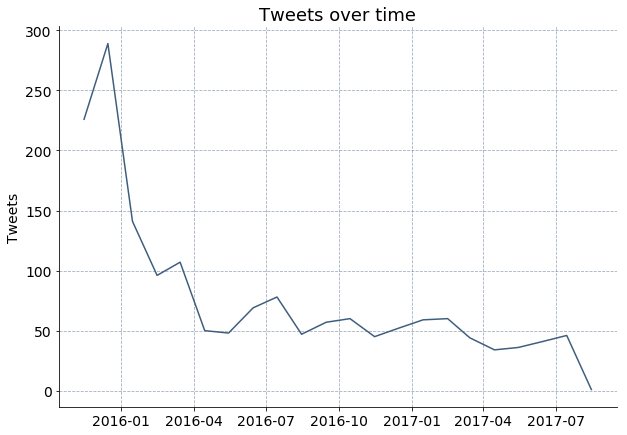

In [75]:
# group data by month and year
tweets_time = pd.DataFrame(df.timestamp)
tweets_time = tweets_time.groupby([df.timestamp.dt.year, tweets_time.timestamp.dt.month]).count()
tweets_time.index = [datetime(year=int(y), month=int(m), day=15) for y, m in tweets_time.index]

# plot
plot_line(tweets_time.index, 
          tweets_time.timestamp,
          title="Tweets over time",
          ylabel="Tweets")

Most of the tweets we have come from the beginning of 2016. Then, the number of tweets gradually decreases. We can suppose that at the beginning, WeRateDogs account created more tweets trying to gain popularity. Once it became popular, the number of tweets fell.

### Tweets by Source

We can also have a look at the source of tweets.

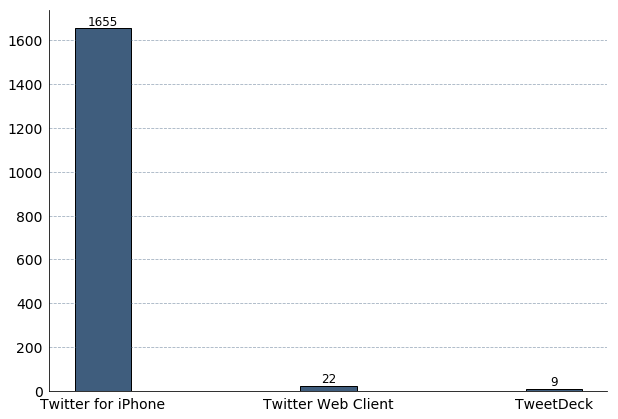

In [76]:
# get value counts and save as dataframe
source_types = pd.DataFrame(df.source.value_counts())

# plot
plot_bar(source_types.index, 
         source_types.source, 
         width=0.25)

It is interesting to see that almost all tweets were created from the iPhone app and only a fraction from the web browser.

### Dog names

Each tweet gives us a lot of information. One of them is a dog name. Thanks to this, we can easily see which dog names are the most popular.

In [77]:
# join all names but skip NaNs
# https://stackoverflow.com/a/944712/7382214
text = " ".join(str(name) for name in df.name if name == name)

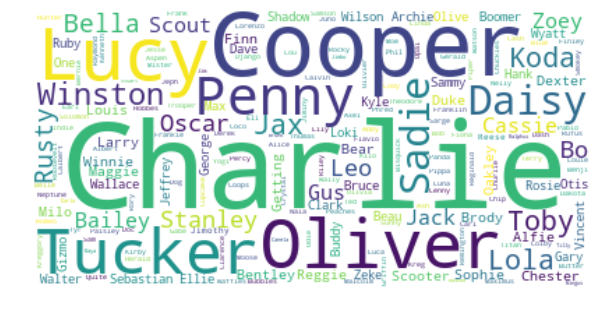

In [78]:
# generate wordCloud with dog names
wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=[10,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As we can see in the above word cloud, Charlie, Cooper, Lucy, Oliver, Tucker, and Penny are the most popular dog names :)

### Dog Types

WeRateDogs classifies dogs into one of four stages: doggo, pupper, puppo, and floof(er). The detail description of each stage is provided below. Let's check how many dogs we have for each category.

<p align="center">
  <img src="img/dogtionary-combined.png">
</p>

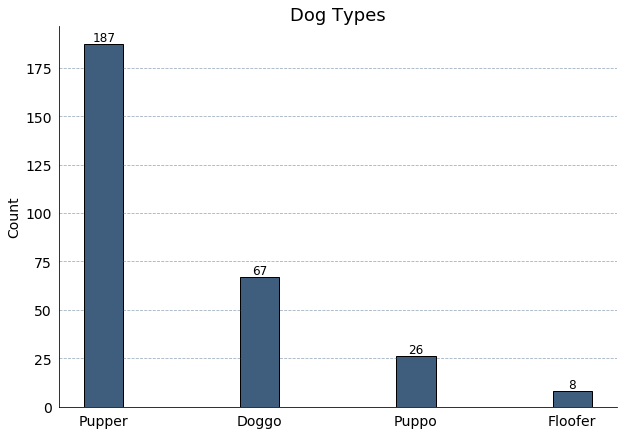

In [79]:
# plot dog types
dog_types = pd.DataFrame(df.dog_type.value_counts())

plot_bar(dog_types.index,
         dog_types.dog_type,
         width=0.25, 
         title="Dog Types", 
         ylabel="Count")

Pupper is the most common dog category, followed by Doggo. Floofer is very rare.

### Dog Breeds

Another interesting information is the dog breed. This information comes from the image predictions file, which we merged with the tweeter archive at the end of the cleaning section. Dog breeds were generated by running images through the neural network that can classify breeds of dogs. Check my [DL--Dog-Breed-Classifier](https://github.com/BarbaraStempien/DL--Dog-Breed-Classifier) repository to see an example of such neural network.

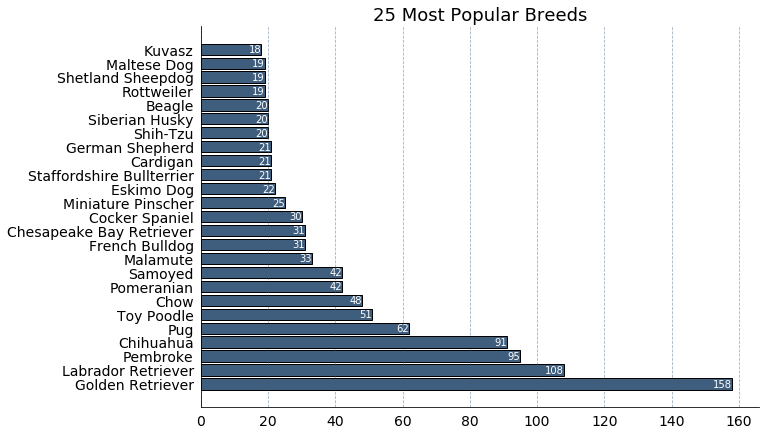

In [80]:
# plot 25 most popular dog breeds
dog_breeds = pd.DataFrame(df.breed_predicted.value_counts()[:25])

plot_barh(dog_breeds.index,
          dog_breeds.breed_predicted,
          title="25 Most Popular Breeds")

Golden Retriever, Labrador Retriever, Pembroke, and Chihuahua are leading! 

Now let's check if any specific dog breed gets a higher rating than others.

In [81]:
# aggregate data
dog_breeds_rating = pd.DataFrame(df[['breed_predicted', 'rating']]).groupby(['breed_predicted'], as_index=False).agg(['mean', 'count'])

# drop multiindex and rename columns
dog_breeds_rating.columns = dog_breeds_rating.columns.droplevel()
dog_breeds_rating.columns = ['rating_mean', 'breed_count']

# sort by rating
dog_breeds_rating.sort_values('rating_mean', ascending=False, inplace=True)

# display sample of data
dog_breeds_rating.sample(3)

,rating_mean,breed_count
breed_predicted,,
Siberian Husky,1.130000,20
Cocker Spaniel,1.133333,30
Standard Poodle,1.072727,11


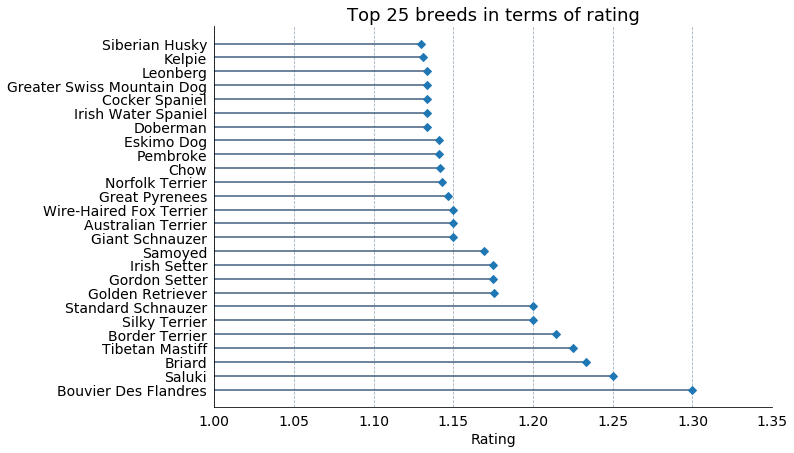

In [82]:
# plot top 25 breeds in terms of rating
df_range = range(1, len(dog_breeds_rating.iloc[:26,:].index) + 1)
 
# Vertical lollipop plot

plt.figure(figsize=(10,7)) 

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='x', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.xticks(fontsize=14)
plt.yticks(df_range, dog_breeds_rating.iloc[:26,:].index, fontsize=14)

plt.xlim(1,1.35)

plt.tick_params(axis="both", which="both", bottom=False, top=False,
                    labelbottom=True, left=False, right=False, labelleft=True) 
    
plt.hlines(y = df_range, xmin = 0, xmax = dog_breeds_rating.iloc[:26,:].rating_mean, color = '#3F5D7D')
plt.plot(dog_breeds_rating.iloc[:26,:].rating_mean, df_range, "D")

plt.title("Top 25 breeds in terms of rating",
          fontsize=18)
    
plt.xlabel("Rating",
           fontsize=14) 
    
plt.show()

The highest rated dog breed is Bouvier Des Flandres, followed by Saluki and Briard. Now, let's see how the most common breeds are rated.

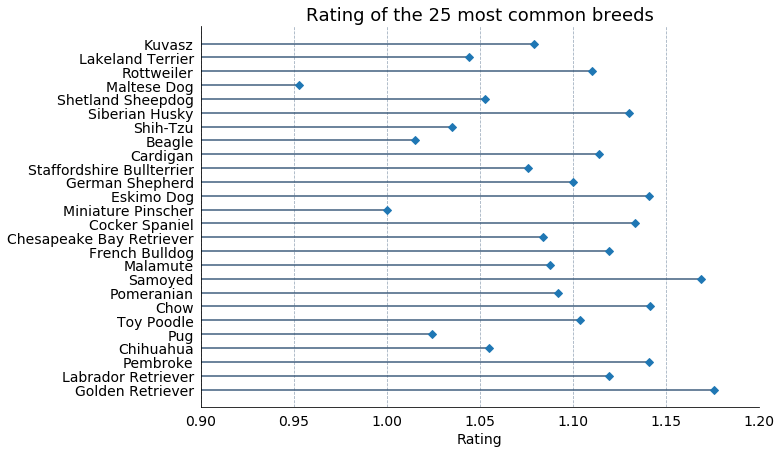

In [83]:
# plot rating of 25 most common breeds
dog_breeds_rating_count = dog_breeds_rating.sort_values('breed_count', ascending=False)
df_range = range(1, len(dog_breeds_rating_count.iloc[:26,:].index) + 1)
 
# Vertical lollipop plot

plt.figure(figsize=(10,7)) 

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)    
ax.grid(which='major', axis='x', linestyle='--', alpha=0.5, color="#3F5D7D")

plt.xticks(fontsize=14)
plt.yticks(df_range, dog_breeds_rating_count.iloc[:26,:].index, fontsize=14)

plt.xlim(0.9,1.2)

plt.tick_params(axis="both", which="both", bottom=False, top=False,
                    labelbottom=True, left=False, right=False, labelleft=True) 
    
plt.hlines(y = df_range, xmin = 0, xmax = dog_breeds_rating_count.iloc[:26,:].rating_mean, color = '#3F5D7D')
plt.plot(dog_breeds_rating_count.iloc[:26,:].rating_mean, df_range, "D")

plt.title("Rating of the 25 most common breeds",
          fontsize=18)
    
plt.xlabel("Rating",
           fontsize=14) 
    
plt.show()

Rating of the most popular dog breeds varies from breed to breed. The most popular Golden Retriever has quite high raring, however very popular Pugs are rated much lower. 

Let's try to understand WeRateDogs rating system a bit better!

### Rating

WeRateDogs rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because ["they're good dogs Brent."](https://knowyourmeme.com/memes/theyre-good-dogs-brent). Let's have a closer look!

<p align="center">
  <img src="img/8c6.jpg" width="400">
</p>

In [84]:
# display basic stats
df.rating.describe()

count    1686.000000
mean     1.085295   
std      0.186785   
min      0.000000   
25%      1.000000   
50%      1.100000   
75%      1.200000   
max      3.428571   
Name: rating, dtype: float64

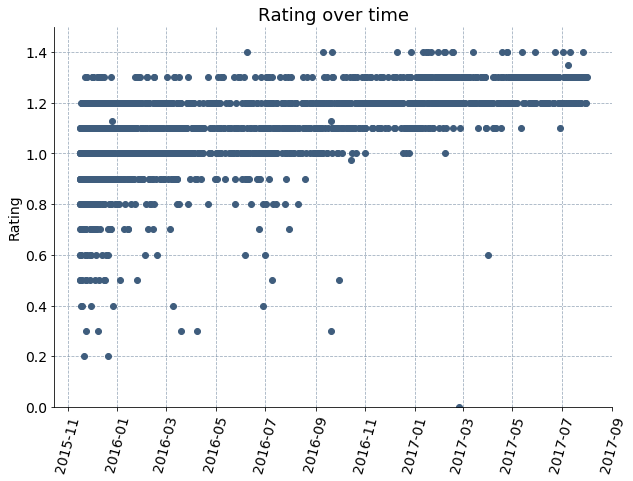

In [85]:
# plot rating over time
plot_line(df.timestamp, 
          df.rating,
          title="Rating over time", 
          ylabel="Rating", 
          marker='o', 
          linestyle='', 
          ylim=(0,1.5), 
          xrotation=75)

At the beginning of the account activity, the lower ratings were more frequent. With the elapse of time, less and less dogs received a low rating, and more and more high. 

Another interesting thing to check if a relation of rating to retweets and favorites.

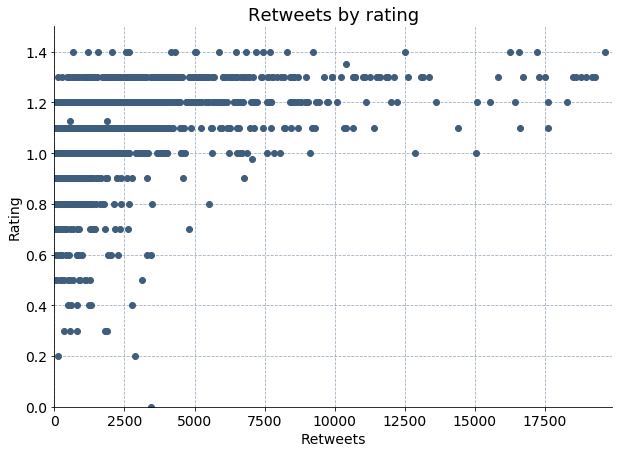

In [86]:
# plot rating and retweets count
rating_quantile = df.rating.quantile(q=0.99)
retweets_quantile = df.retweets.quantile(q=0.99)

plot_line(df.retweets, 
          df.rating,
          title="Retweets by rating",
          xlabel="Retweets", 
          ylabel="Rating",
          marker='o', 
          linestyle='',
          ylim=(0, rating_quantile + 0.1),
          xlim=(0, retweets_quantile))

As we can see in the above plot, tweets with high ratings are often retweeted. Let's see if the same relationship exists for favorites.

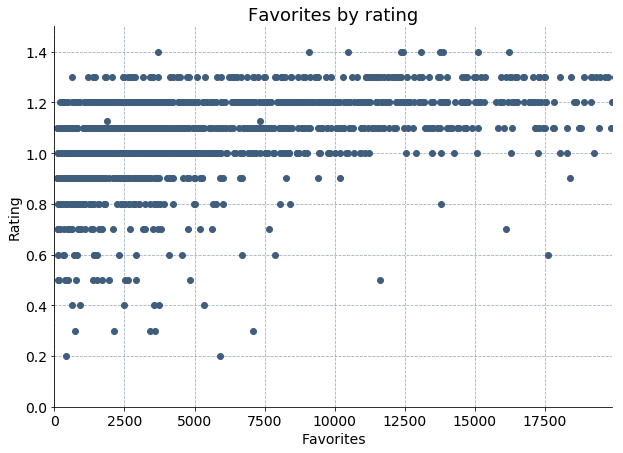

In [87]:
# plot rating and favorites count
favorites_quantile = df.favorites.quantile(q=0.99)

plot_line(df.favorites, 
          df.rating,
          title="Favorites by rating",
          xlabel="Favorites", 
          ylabel="Rating",
          marker='o', 
          linestyle='',
          ylim=(0, rating_quantile + 0.1),
          xlim=(0, retweets_quantile))

Here again, we see that the higher rating links with more favorites. Retweets and favorites and generally very interesting, so now we look closer at these two.

### Favorites and Retweets 

In [88]:
# display basic stats
df.favorites.describe()

count    1686.000000  
mean     9233.109727  
std      12583.246963 
min      81.000000    
25%      2163.250000  
50%      4440.000000  
75%      11656.750000 
max      132810.000000
Name: favorites, dtype: float64

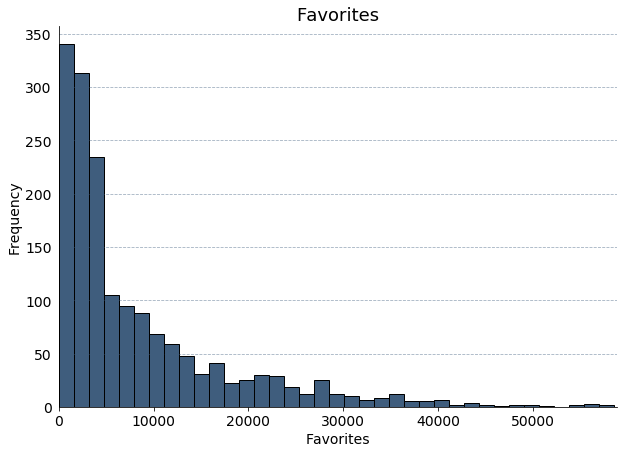

In [89]:
# plot favorites frequency
favorites_quantile = df.favorites.quantile(q=0.99)

plot_hist(df.favorites,
          title="Favorites",
          xlabel="Favorites",
          ylabel="Frequency",
          xlim=(0,favorites_quantile))

Most of the posts get less than 11k favorites (75% quartile). The average number of favorites is 9233.

The most popular tweet had 132810 favorites. Let's see that tweet:

Here's a super supportive puppo participating in the Toronto  #WomensMarch today. 13/10 https://t.co/nTz3FtorBc


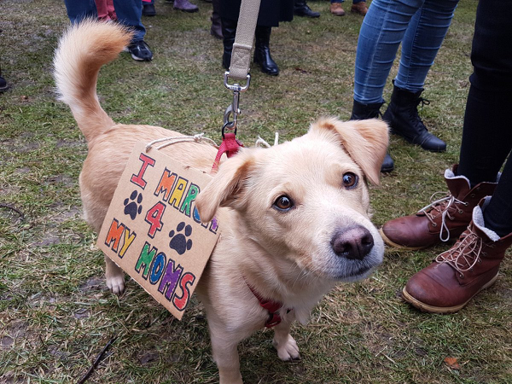

In [90]:
# get tweet text
text = df.loc[df.favorites.idxmax()]['text']

# get tweet image
size = 512, 512
image_url = df.loc[df.favorites.idxmax()]['image_url']
image = Image.open(requests.get(image_url, stream=True).raw)
image.thumbnail(size)

# display text and image
print(text)
image

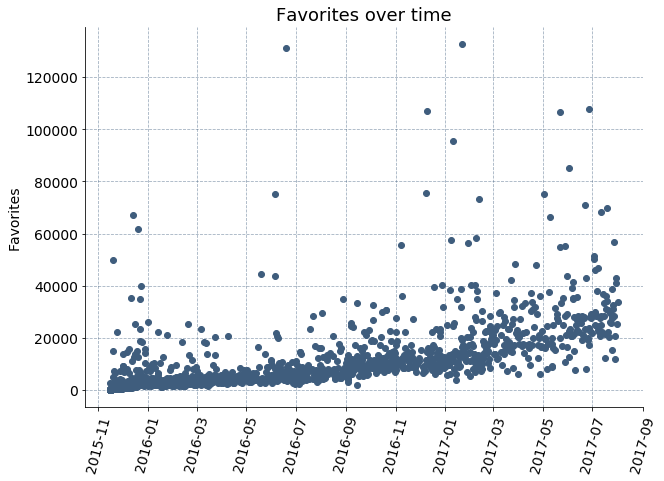

In [91]:
# plot favorites over time
plot_line(df.timestamp, 
          df.favorites,
          title="Favorites over time", 
          ylabel="Favorites", 
          marker='o', 
          linestyle='',
          xrotation=75)

We see an upward trend in the number of favorites. We can suppose that tweets were getting more and more favorites as WeRateDog account was becoming more and more popular. Now, let's look at retweets.

In [92]:
# display basic stats
df.retweets.describe()

count    1686.000000 
mean     2817.118031 
std      4807.199770 
min      16.000000   
25%      649.250000  
50%      1437.500000 
75%      3247.750000 
max      79515.000000
Name: retweets, dtype: float64

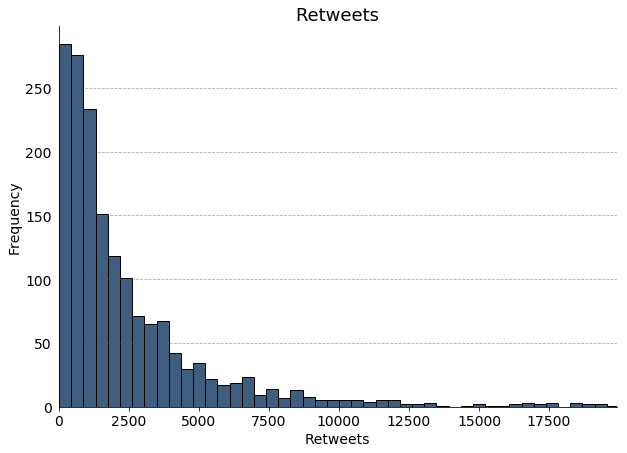

In [93]:
# plot retweets frequency
retweets_quantile = df.retweets.quantile(q=0.99)

plot_hist(df.retweets,
          title="Retweets",
          xlabel="Retweets",
          ylabel="Frequency",
          xlim=(0,retweets_quantile))

Most of the tweets get less than 3k retweets (75% quartile). The average number of retweets is 2817. The most popular tweet had 79515 retweets. Let's see that tweet:

Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4


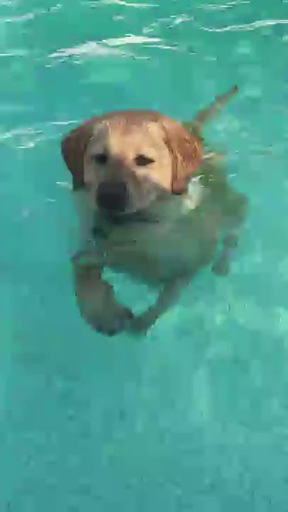

In [94]:
# get tweet text
text = df.loc[df.retweets.idxmax()]['text']

# get tweet image
size = 512, 512
image_url = df.loc[df.retweets.idxmax()]['image_url']
image = Image.open(requests.get(image_url, stream=True).raw)
image.thumbnail(size)

# display text and image
print(text)
image

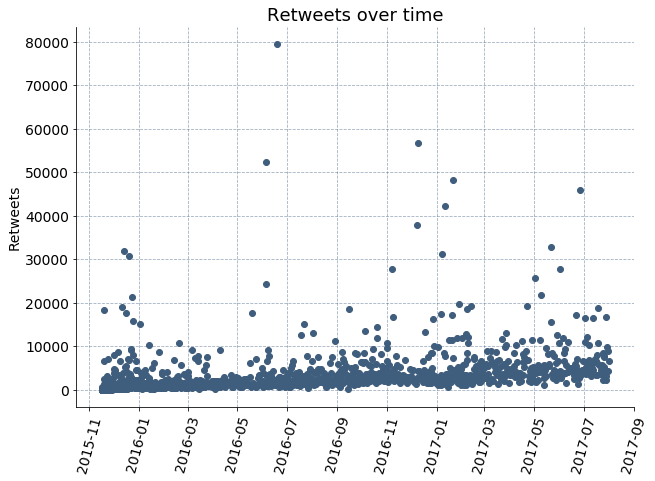

In [95]:
# plot retweets over time
plot_line(df.timestamp, 
          df.retweets,
          title="Retweets over time", 
          ylabel="Retweets", 
          marker='o', 
          linestyle='',
          xrotation=75)

The amount of retweets seems to be quite constant, with a slight increase in recent years. Now let's look at the retweets and favorites relation.

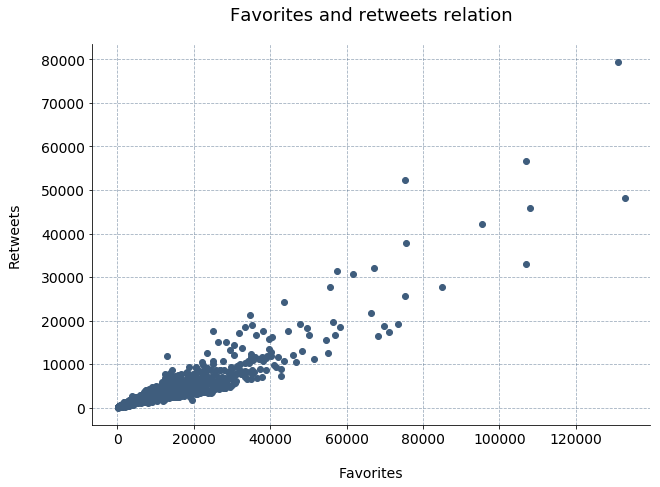

In [96]:
# plot favorites and retweets
plot_scatter(df.favorites,
             df.retweets,
             title="Favorites and retweets relation",
             xlabel="Favorites",
             ylabel="Retweets")

In the plot above, we see correlations between the values. This relationship will be even more evident if we use log10.

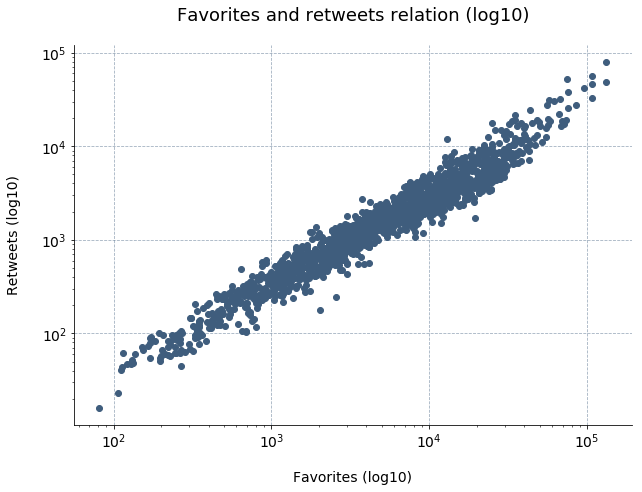

In [97]:
# plot favorites and retweets log10
plot_scatter(df.favorites,
             df.retweets, 
             title="Favorites and retweets relation (log10)",
             xlabel="Favorites (log10)",
             ylabel="Retweets (log10)",
             xscale="log", 
             yscale="log")

After using log10, the correlation very visible. 

## Conclusions

In this notebook, I tried to look closely at the data associated with the WeRateDogs account on the tweeter. I have loaded data from three different sources, then I cleared the data and finally analyzed it. This allowed a better understanding of the profile's activities on the tweeter.